In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import h5py
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
import gc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.layers import TimeDistributed, Reshape, Permute
from keras.utils import to_categorical
from tensorflow import keras
import pywt


In [ ]:
# ------------------------------ Train Data ------------------------------ #

In [3]:
def meg_data_generator(data_folder, task_numbers, batch_size):
  while True:
      for task in task_numbers:
          file_paths, labels = get_file_paths_and_labels(data_folder, task)
          for i in range(0, len(file_paths), batch_size):
              batch_paths = file_paths[i:i + batch_size]
              batch_labels = labels[i:i + batch_size]

              batch_data = []
              for path in batch_paths:
                  data = load_data(path)
                  data = preprocess_data(data)  # scaling, filtering, downsampling.
                  batch_data.append(data)

              print("Data appended:", data.shape)
              yield np.array(batch_data), to_categorical(np.array(batch_labels), num_classes=4)

# Helper function to get file paths and labels
def get_file_paths_and_labels(data_folder, task_numbers):
    file_paths = []
    labels = []
    for task_number in task_numbers:
        for file in os.listdir(data_folder):
            if file.endswith(task_number + 'h5'):
                file_path = os.path.join(data_folder, file)
                file_paths.append(file_path)
                labels.append(assign_label(file))
    return file_paths, labels

# Include your preprocessing steps here
def preprocess_data(data):
  data = data[:, :-8]
  data = apply_scaling(data)
  data = apply_lowpass(data)
  data = apply_downsampling(data)
  print("data after preprocessing:", data.shape)
  return data

def load_data(file_path):
    with h5py.File(file_path, 'r') as f:
        dataset_name = get_dataset_name(file_path)
        matrix = f.get(dataset_name)[:]
        return matrix

def get_dataset_name(file_name_with_dir):
    filename_without_dir = file_name_with_dir.split('/')[-1]
    temp = filename_without_dir.split('_')[:-1]
    dataset_name = "_".join(temp)
    return dataset_name

def assign_label(file_name):
    if file_name.startswith("rest"):
        print(file_name, "REST")
        return 0
    elif file_name.startswith("task_motor"):
        print(file_name, "MOTOR")
        return 1
    elif file_name.startswith("task_story"):
        print(file_name, "STORY")
        return 2
    elif file_name.startswith("task_working"):
        print(file_name, "WORKING")
        return 3
    else:
        return None

def count_files_with_task_numbers(data_folder, task_numbers):
    total_files = 0
    for file in os.listdir(data_folder):
        if any(file.endswith(task_number + 'h5') for task_number in task_numbers):
            total_files += 1
    return total_files


def find_fmri_data_folder(start_path):
    for root, dirs, files in os.walk(start_path):
        if 'meg_data' in dirs:
            return os.path.join(root, 'meg_data/Intra/train')
    raise Exception("meg_data folder not found. Please check the directory structure.")


def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y



def apply_scaling(array):
  print("array scaling", array.shape)
  array_norm = np.zeros((array.shape[0],array.shape[1]))
  for i in range(array.shape[0]):
    means = np.mean(array[i])  # Calculate mean for each sensor
    stds = np.std(array[i])    # Calculate standard deviation for each sensor
    array_norm[i] = (array[i] - means) / stds   # Subtrack and divide

  del array, means, stds
  gc.collect()
  return array_norm


def apply_lowpass(array):
  original_sampling_rate = 2034  # Original sampling rate
  downsampling_factor = 4
  new_sampling_rate = original_sampling_rate / downsampling_factor  # New sampling rate after downsampling
  cutoff_frequency = new_sampling_rate / 2  # Nyquist frequency

  array_filtered = np.zeros((array.shape[0], array.shape[1]))

  for i in range(array.shape[0]):  # Iterate over sensors
      array_filtered[i, :] = butter_lowpass_filter(array[i, :], cutoff_frequency, original_sampling_rate)

  del array
  return array_filtered


def apply_downsampling(array):
  n_sensors, n_timepoints = array.shape

  downsampling_factor = 4
  new_n_timepoints = n_timepoints // downsampling_factor
  array_downsamp = np.zeros((n_sensors, new_n_timepoints))

  for sensor in range(n_sensors):
    array_downsamp[sensor,:] = array[sensor, ::downsampling_factor]

  del array, new_n_timepoints, downsampling_factor, n_sensors, n_timepoints
  gc.collect()
  return array_downsamp


def build_model():
    model = Sequential()

    # Convolutional layers
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(248, 8904)))
    model.add(BatchNormalization())
    # model.add(Dropout(0.5))

    model.add(Conv1D(filters=512, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    # model.add(Dropout(0.5))

    # Flatten the output to feed into the LSTM layer
    model.add(Permute((2, 1)))

    # LSTM layer
    model.add(LSTM(256, return_sequences=True))
    model.add(LSTM(128))

    # Dense layers for classification
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))

    # Output layer
    model.add(Dense(4, activation='softmax')) # Assuming 4 motor tasks

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model



fmri_data_folder = find_fmri_data_folder('/content/drive/My Drive')
print("fmri_data_folder:", fmri_data_folder)
task_numbers = ['_1.','_2.','_3.','_4.','_5.','_6.','_7.','_8.']
batch_size = 4
epochs = 4

# Initialize model here
model = build_model()

# Create data generator
train_generator = meg_data_generator(fmri_data_folder, task_numbers, batch_size)
print("train_generator", train_generator)


# Determine the number of steps per epoch
total_files = count_files_with_task_numbers(fmri_data_folder, task_numbers)
print(total_files)
steps_per_epoch = total_files // batch_size

# Train the model
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs)


fmri_data_folder: /content/drive/My Drive/Courses/Pattern Recognition/Lab/Group Assignment/meg_data/Intra/train
train_generator <generator object meg_data_generator at 0x7c02200c1af0>
32
task_story_math_105923_6.h5 STORY
task_working_memory_105923_6.h5 WORKING
task_motor_105923_6.h5 MOTOR
task_motor_105923_5.h5 MOTOR
task_story_math_105923_2.h5 STORY
rest_105923_6.h5 REST
task_working_memory_105923_1.h5 WORKING
task_motor_105923_8.h5 MOTOR
task_story_math_105923_4.h5 STORY
task_working_memory_105923_3.h5 WORKING
task_working_memory_105923_5.h5 WORKING
task_story_math_105923_5.h5 STORY
rest_105923_2.h5 REST
rest_105923_3.h5 REST
rest_105923_4.h5 REST
task_story_math_105923_3.h5 STORY
task_motor_105923_3.h5 MOTOR
task_working_memory_105923_2.h5 WORKING
task_story_math_105923_8.h5 STORY
task_story_math_105923_7.h5 STORY
task_story_math_105923_1.h5 STORY
rest_105923_7.h5 REST
rest_105923_5.h5 REST
rest_105923_8.h5 REST
task_motor_105923_1.h5 MOTOR
task_motor_105923_2.h5 MOTOR
task_working_

In [ ]:
# ------------------------------ Test data ------------------------------ #

In [4]:
# Retrieve Test data

def find_fmri_data_folder(start_path):
    for root, dirs, files in os.walk(start_path):
        if 'meg_data' in dirs:
            return os.path.join(root, 'meg_data/Intra/test')
    raise Exception("meg_data folder not found. Please check the directory structure.")

def get_dataset_name(file_name_with_dir):
    filename_without_dir = file_name_with_dir.split('/')[-1]
    temp = filename_without_dir.split('_')[:-1]
    dataset_name = "_".join(temp)
    return dataset_name

def assign_label(file_name):
    if file_name.startswith("rest"):
        print(file_name, "REST")
        return 0
    elif file_name.startswith("task_motor"):
        print(file_name, "MOTOR")
        return 1
    elif file_name.startswith("task_story"):
        print(file_name, "STORY")
        return 2
    elif file_name.startswith("task_working"):
        print(file_name, "WORKING")
        return 3
    else:
        return None

def load_data(file_path):
    with h5py.File(file_path, 'r') as f:
        dataset_name = get_dataset_name(file_path)
        matrix = f.get(dataset_name)[:]
        return matrix

fmri_data_folder = find_fmri_data_folder('/content/drive/My Drive')
meg_test_data_list = []
labels_test = []

for file in os.listdir(fmri_data_folder):
    if file.endswith('.h5'):
        file_path = os.path.join(fmri_data_folder, file)
        data = load_data(file_path)
        meg_test_data_list.append(data)
        labels_test.append(assign_label(file))

        # Clear memory
        del data
        gc.collect()

# Convert the list of 2D arrays into a single 3D NumPy array
meg_test_data_array = np.stack(meg_test_data_list, axis=0)
labels_test_array = np.array(labels_test)

meg_test_data_array = meg_test_data_array[:, :, :-8]


def apply_scaling(array):
  array_norm = np.zeros((array.shape[0],array.shape[1],array.shape[2]))
  for i in range(array.shape[0]):
    means = np.mean(array[i], axis=1)  # Calculate mean for each sensor
    stds = np.std(array[i], axis=1)    # Calculate standard deviation for each sensor
    array_norm[i] = (array[i] - means[:, np.newaxis]) / stds[:, np.newaxis]   # Subtrack and divide

  del array, means, stds
  gc.collect()
  return array_norm

def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def apply_lowpass(array):
  original_sampling_rate = 2034  # Original sampling rate
  downsampling_factor = 4
  new_sampling_rate = original_sampling_rate / downsampling_factor  # New sampling rate after downsampling
  cutoff_frequency = new_sampling_rate / 2  # Nyquist frequency

  array_filtered = np.zeros_like(array)

  for o in range(array.shape[0]):
      for i in range(array.shape[1]):
          array_filtered[o, i, :] = butter_lowpass_filter(array[o, i, :], cutoff_frequency, original_sampling_rate)

  del array
  return array_filtered


  del array
  gc.collect()
  return array_filtered


def apply_downsampling(array):
  n_observations, n_sensors, n_timepoints = array.shape
  new_n_timepoints = n_timepoints // 4
  downsampling_factor = 4
  array_downsamp = np.zeros((n_observations, n_sensors, new_n_timepoints))

  for obs in range(n_observations):
    for sensor in range(n_sensors):
      array_downsamp[obs,sensor,:] = array[obs, sensor, ::downsampling_factor]

  del array, new_n_timepoints, downsampling_factor, n_observations, n_sensors, n_timepoints
  gc.collect()
  return array_downsamp


X_task_norm = apply_scaling(meg_test_data_array)
del meg_test_data_array
gc.collect()

# Lowpass filter
X_task_filtered = apply_lowpass(X_task_norm)
del X_task_norm
gc.collect()

# Downsample
X_task_downsamp = apply_downsampling(X_task_filtered)
del X_task_filtered
gc.collect()



obs_test, sensors_test, points_test = X_task_downsamp.shape
X_test = X_task_downsamp.reshape(obs_test, sensors_test, points_test)
y_test_encoded = to_categorical(labels_test_array, num_classes=4)

task_motor_105923_10.h5 MOTOR
task_working_memory_105923_9.h5 WORKING
task_story_math_105923_10.h5 STORY
task_story_math_105923_9.h5 STORY
task_motor_105923_9.h5 MOTOR
rest_105923_9.h5 REST
task_working_memory_105923_10.h5 WORKING
rest_105923_10.h5 REST


In [5]:
X_test.shape

(8, 248, 8904)

In [6]:
y_test_encoded

array([[0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]], dtype=float32)

In [7]:
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)

1/1 [==============================] - 2s 2s/step - loss: 1.8963 - accuracy: 0.5000


In [8]:
X_test.shape

(8, 248, 8904)

In [9]:
labels_test_array

array([1, 3, 2, 2, 1, 0, 3, 0])

In [10]:
# Manually evaluate the model on a small batch of test data
predicted_labels = []
actual_labels = np.argmax(y_test_encoded, axis=1)

for i in range(len(X_test)):  # Just an example to check the first few samples
    sample = np.expand_dims(X_test[i], axis=0)
    print("sample shape:", sample.shape)
    prediction = model.predict(sample)
    actual_label = np.argmax(y_test_encoded[i])
    predicted_label = np.argmax(prediction)
    print(f"Sample {i}: Actual Label = {actual_label}, Predicted Label = {predicted_label}")
    predicted_labels.append(predicted_label)


sample shape: (1, 248, 8904)
1/1 [==============================] - 1s 1s/step
Sample 0: Actual Label = 1, Predicted Label = 2
sample shape: (1, 248, 8904)
1/1 [==============================] - 0s 406ms/step
Sample 1: Actual Label = 3, Predicted Label = 2
sample shape: (1, 248, 8904)
1/1 [==============================] - 0s 426ms/step
Sample 2: Actual Label = 2, Predicted Label = 2
sample shape: (1, 248, 8904)
1/1 [==============================] - 0s 421ms/step
Sample 3: Actual Label = 2, Predicted Label = 2
sample shape: (1, 248, 8904)
1/1 [==============================] - 0s 411ms/step
Sample 4: Actual Label = 1, Predicted Label = 2
sample shape: (1, 248, 8904)
1/1 [==============================] - 0s 422ms/step
Sample 5: Actual Label = 0, Predicted Label = 0
sample shape: (1, 248, 8904)
1/1 [==============================] - 0s 416ms/step
Sample 6: Actual Label = 3, Predicted Label = 1
sample shape: (1, 248, 8904)
1/1 [==============================] - 0s 444ms/step
Sample 7: A

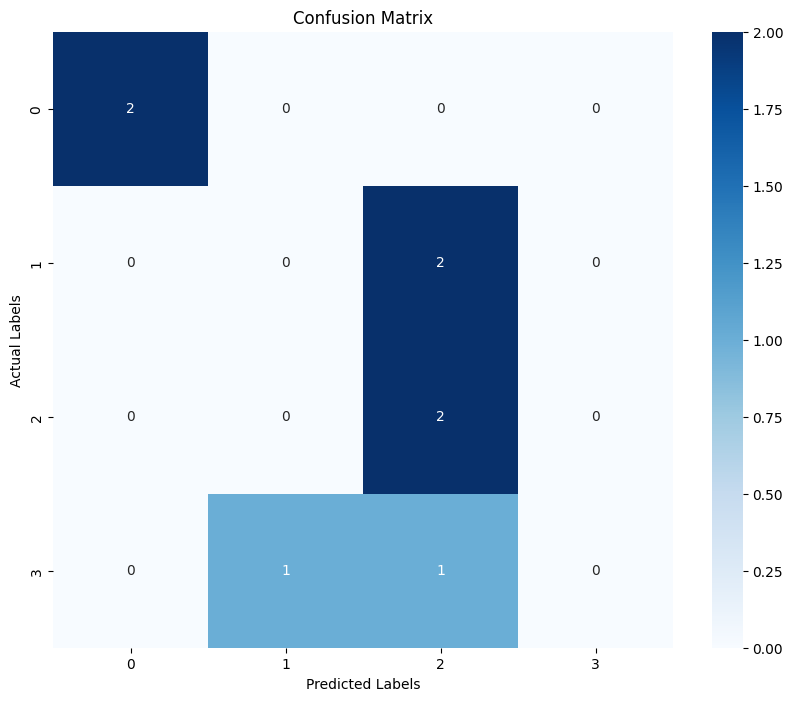

In [11]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(labels_test_array, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()


In [ ]:
'''
sample shape: (1, 248, 8904)
1/1 [==============================] - 1s 628ms/step
Sample 0: Actual Label = 1, Predicted Label = 3
sample shape: (1, 248, 8904)
1/1 [==============================] - 1s 638ms/step
Sample 1: Actual Label = 3, Predicted Label = 0
sample shape: (1, 248, 8904)
1/1 [==============================] - 0s 491ms/step
Sample 2: Actual Label = 2, Predicted Label = 2
sample shape: (1, 248, 8904)
1/1 [==============================] - 0s 480ms/step
Sample 3: Actual Label = 2, Predicted Label = 2
sample shape: (1, 248, 8904)
1/1 [==============================] - 0s 482ms/step
Sample 4: Actual Label = 1, Predicted Label = 2
sample shape: (1, 248, 8904)
1/1 [==============================] - 0s 492ms/step
Sample 5: Actual Label = 0, Predicted Label = 0
sample shape: (1, 248, 8904)
1/1 [==============================] - 1s 554ms/step
Sample 6: Actual Label = 3, Predicted Label = 3
sample shape: (1, 248, 8904)
1/1 [==============================] - 1s 501ms/step
Sample 7: Actual Label = 0, Predicted Label = 0
'''